In [87]:
import os
from IPython.display import Image

import pandas as pd
import numpy as np
import itertools
import timeit

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn import tree
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Display all columns
pd.set_option('display.max_columns', None)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

from collections import Counter
from numpy import where
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from numpy import mean
from sklearn.metrics import silhouette_score, homogeneity_score

In [2]:
df_patient = pd.read_csv("data/patientSurvivalPredication.csv")

assert df_patient.shape[0] > 0
assert df_patient.shape[1] > 0

print(f"Data has {df_patient.shape[0]} rows and {df_patient.shape[1]} columns.")

Data has 91713 rows and 85 columns.


In [3]:
df_patient.drop(['encounter_id', 'patient_id', 'hospital_id', 'Unnamed: 83'], inplace=True, axis=1)

In [4]:
df_patient.fillna(-1, inplace=True)

# Replace -1 with empty string in string columns types
df_patient['ethnicity'].replace(-1, '', inplace=True)
df_patient['gender'].replace(-1, '', inplace=True)
df_patient['icu_stay_type'].replace(-1, "", inplace=True)
df_patient['icu_admit_source'].replace(-1, '', inplace=True)
df_patient['icu_type'].replace(-1, '', inplace=True)
df_patient['apache_3j_bodysystem'].replace(-1, '', inplace=True)
df_patient['apache_2_bodysystem'].replace(-1, '', inplace=True)

# Encode ethinicity as decision tree can't handle string values
enc = LabelEncoder()
enc.fit(df_patient['ethnicity'])

# Correct different spelling for same values
df_patient['apache_2_bodysystem'].replace("Undefined diagnoses", "Undefined Diagnoses", inplace=True)

# Create dummy columns for string columns so decision tree can proccess them
df_patient = pd.get_dummies(df_patient, columns=["ethnicity", "gender", "icu_stay_type", "icu_admit_source", "icu_type", "apache_3j_bodysystem", "apache_2_bodysystem"], prefix=["ethnicity_is", "gender_is", "icu_stay_type_is", "icu_admit_source_is", "icu_type_is", "apache_3j_bodysystem_is", "apache_2_bodysystem_is"] )

print(df_patient.shape)

(91713, 123)


In [41]:
from collections import Counter
from numpy import where
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from numpy import mean


patient_Y = df_patient['hospital_death']
patient_X = df_patient.loc[:, df_patient.columns != 'hospital_death']

# X_train, X_test, y_train, y_test = train_test_split(np.array(patient_X),np.array(patient_Y), test_size=0.15)

class_count = Counter(patient_Y)
print(class_count)

# define model
model = DecisionTreeClassifier(max_depth=20, random_state=100, min_samples_leaf=10, criterion='entropy')
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=100)
scores = cross_val_score(model, patient_X, patient_Y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))



Counter({0: 27594, 1: 2406})
Mean ROC AUC: 0.733


In [116]:
# Apply undersampling and oversampling
X_train, X_test, y_train, y_test = train_test_split(np.array(patient_X),np.array(patient_Y), test_size=0.15)

model = DecisionTreeClassifier(max_depth=20, random_state=100, min_samples_leaf=10, criterion='entropy')
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=100)
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print(scores)
print('Mean CV ROC AUC: %.3f' % mean(scores))

# Test scores
print(pipeline)
pipeline.fit(X_train, y_train)
y_pred_test = pipeline.predict(X_test)
test_scores = roc_auc_score(y_test, y_pred_test)
print(test_scores)
print('Mean Test ROC AUC: %.3f' % mean(test_scores))

[0.80399657 0.79563857 0.81522409 0.7944128  0.79421383 0.80367876
 0.77851592 0.79287259 0.77500562 0.80867771 0.79801973 0.79607465
 0.8150942  0.78845714 0.8150076  0.79677258 0.79067053 0.78161385
 0.80438391 0.81726429 0.76404329 0.78068911 0.79632825 0.80267154
 0.77340253 0.77769221 0.82503438 0.81794986 0.80935194 0.78041798]
Mean CV ROC AUC: 0.796
Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=20,
                                        min_samples_leaf=10,
                                        random_state=100))])
0.7090516212130176
Mean Test ROC AUC: 0.709


In [37]:
df_insurance = pd.read_csv('data/insurance/train.csv', nrows=100000)

assert df_insurance.shape[0] > 0
assert df_insurance.shape[1] > 0

print(f"Data has {df_insurance.shape[0]} rows and {df_insurance.shape[1]} columns.")

def encode_labels(df):
    for column in df.columns:
        if df[column].dtype=='object':
            label = LabelEncoder()
            label.fit(list(df[column].values))
            df[column] = label.transform(list(df[column].values))
    return df

df_insurance = df_insurance.drop(['QuoteNumber'], axis=1)

# Now convert the date to day, month and week and drop the date
df_insurance['Date'] = pd.to_datetime(pd.Series(df_insurance['Original_Quote_Date']))
df_insurance = df_insurance.drop('Original_Quote_Date', axis=1)
df_insurance['Year'] = df_insurance['Date'].apply(lambda x: int(str(x)[:4]))
df_insurance['Month'] = df_insurance['Date'].apply(lambda x: int(str(x)[5:7]))
df_insurance['weekday'] = df_insurance['Date'].dt.dayofweek
df_insurance = df_insurance.drop('Date', axis=1)
df_insurance = encode_labels(df_insurance)
df_insurance = df_insurance.fillna(-1)

insurance_X = df_insurance.loc[:, df_insurance.columns != 'QuoteConversion_Flag']
insurance_Y = df_insurance['QuoteConversion_Flag']

Data has 100000 rows and 299 columns.


In [ ]:
insurance_X_train, insurance_X_test, insurance_y_train, insurance_y_test = train_test_split(np.array(insurance_X),np.array(insurance_Y), test_size=0.15)

model = DecisionTreeClassifier(max_depth=20, random_state=100, min_samples_leaf=10, criterion='entropy')
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline_ins = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=100)
scores = cross_val_score(pipeline_ins, insurance_X_train, insurance_y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print(scores)
print('Mean CV ROC AUC: %.3f' % mean(scores))

# Test scores
pipeline_ins.fit(insurance_X_train, insurance_y_train)
insurance_y_pred_test = pipeline_ins.predict(insurance_X_test)
test_scores = roc_auc_score(insurance_y_test, insurance_y_pred_test)
print('Mean Test ROC AUC: %.3f' % mean(test_scores))

In [48]:
from imblearn.over_sampling import BorderlineSMOTE
model = DecisionTreeClassifier(max_depth=20, random_state=100, min_samples_leaf=10, criterion='entropy')
over = BorderlineSMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=100)
scores = cross_val_score(pipeline, patient_X, patient_Y, scoring='roc_auc', cv=cv, n_jobs=-1)
print(scores)
print('Mean ROC AUC: %.3f' % mean(scores))

[0.77618056 0.78431688 0.79388662 0.80030873 0.80325573 0.77658557
 0.81986753 0.80435211 0.79270783 0.80617414 0.8130631  0.77608243
 0.80544082 0.78974109 0.78431057 0.80217891 0.8059117  0.79080459
 0.79418847 0.78596942 0.80023626 0.81316048 0.79470788 0.77084692
 0.75693882 0.80140589 0.80230449 0.80834808 0.79237321 0.77977393]
Mean ROC AUC: 0.794


In [49]:
from imblearn.over_sampling import SVMSMOTE
model = DecisionTreeClassifier(max_depth=20, random_state=100, min_samples_leaf=10, criterion='entropy')
over = SVMSMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=100)
scores = cross_val_score(pipeline, patient_X, patient_Y, scoring='roc_auc', cv=cv, n_jobs=-1)
print(scores)
print('Mean ROC AUC: %.3f' % mean(scores))

[0.77137153 0.7896875  0.80021513 0.77810462 0.78919237 0.79909733
 0.78062065 0.78974507 0.80306925 0.78936532 0.78205842 0.80302612
 0.80327219 0.77613074 0.78896226 0.79678427 0.82845805 0.78685299
 0.78025895 0.81276291 0.78645154 0.82371754 0.81371528 0.79572388
 0.80300458 0.77753756 0.78432787 0.79457648 0.7993312  0.75903381]
Mean ROC AUC: 0.793


In [52]:
from imblearn.over_sampling import ADASYN
model = DecisionTreeClassifier(max_depth=20, random_state=100, min_samples_leaf=10, criterion='entropy')
over = ADASYN()
under = RandomUnderSampler()
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=100)
scores = cross_val_score(pipeline, patient_X, patient_Y, scoring='roc_auc', cv=cv, n_jobs=-1)
print(scores)
print('Mean ROC AUC: %.3f' % mean(scores))

[0.75155722 0.75402627 0.72334466 0.74595637 0.74918298 0.74696768
 0.76259138 0.77443192 0.75834726 0.74720304 0.76623415 0.72127793
 0.74342844 0.72818992 0.75915563 0.73225611 0.77024119 0.72938734
 0.72973475 0.73912988 0.72688255 0.77770003 0.75911458 0.74365414
 0.72700284 0.72606588 0.75446709 0.77227602 0.74978832 0.73374501]
Mean ROC AUC: 0.747


In [5]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()

    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)

    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean"
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [54]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 


over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]

patient_Y = df_patient['hospital_death']
patient_X = df_patient.loc[:, df_patient.columns != 'hospital_death']
patient_X_resample, patient_Y_resample = Pipeline(steps=steps).fit_resample(patient_X, patient_Y)
patient_X_resample_scaled = StandardScaler().fit_transform(patient_X_resample) 

over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]

insurance_X = df_insurance.loc[:, df_insurance.columns != 'QuoteConversion_Flag']
insurance_Y = df_insurance['QuoteConversion_Flag']
insurance_X_resample, insurance_Y_resample = Pipeline(steps=steps).fit_resample(insurance_X, insurance_Y)
insurance_X_resample_scaled = StandardScaler().fit_transform(insurance_X_resample) 

patient_X_train, patient_X_test, patient_y_train, patient_y_test = train_test_split(np.array(patient_X_resample),np.array(patient_Y_resample), test_size=0.15)
insurance_X_train, insurance_X_test, insurance_y_train, insurance_y_test = train_test_split(np.array(insurance_X_resample),np.array(insurance_Y_resample), test_size=0.15)



In [13]:
from collections import Counter

print(Counter(patient_y_train))
Counter(Counter(insurance_y_train))

Counter({0: 14251, 1: 7115})


Counter({1: 20742, 0: 41337})

In [18]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture


def calculate_elbow_silhouette_kmeans(data, kmax):
    elbow = []
    silhouette = []
    for k in range(2, kmax+1):
        classifier = KMeans(k).fit(X=data)
        cluster_labels = classifier.fit_predict(X=data)
        elbow.append(classifier.inertia_)
        silhouette.append(silhouette_score(data, cluster_labels, metric = 'euclidean'))
    
    fig = plt.figure(figsize=(15, 5))
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.xticks(range(2, kmax+1))
    plt.plot(range(2, kmax+1), elbow)
    plt.grid(True)
    plt.title('Elbow curve')
    
    fig = plt.figure(figsize=(15, 5))
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette score")
    plt.xticks(range(2, kmax+1))
    plt.plot(range(2, kmax+1), silhouette)
    plt.grid(True)
    plt.title('Silhouette curve')
    
    return elbow, silhouette


def calculate_silhouette_gaussian(data, kmax):
    silhouette = []
    for k in range(2, kmax+1):
        classifier = GaussianMixture(k).fit(X=data)
        cluster_labels = classifier.fit_predict(X=data)
        silhouette.append(silhouette_score(data, cluster_labels, metric = 'euclidean', sample_size=10000))
    
    fig = plt.figure(figsize=(15, 5))
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette score")
    plt.xticks(range(2, kmax+1))
    plt.plot(range(2, kmax+1), silhouette)
    plt.grid(True)
    plt.title('Silhouette curve')
    
    return silhouette


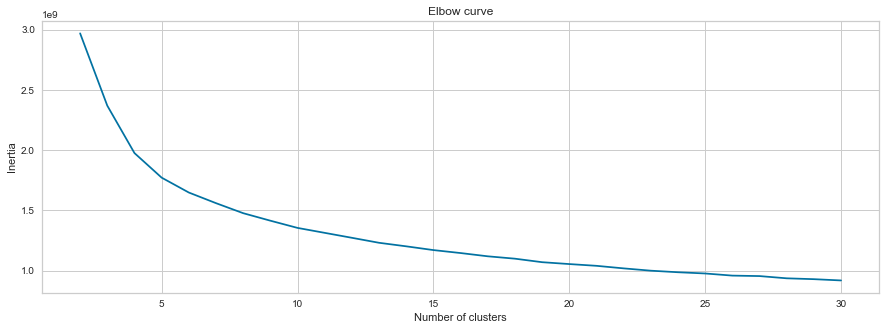

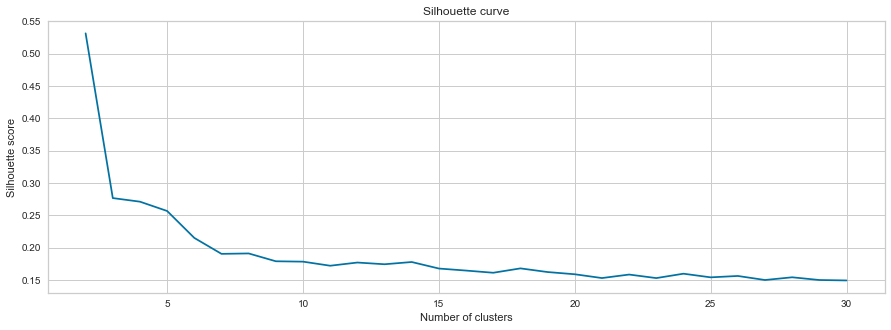

In [240]:
sse_patient, silhouette_patient = calculate_elbow_silhouette_kmeans(patient_X_train, patient_y_train, 30)

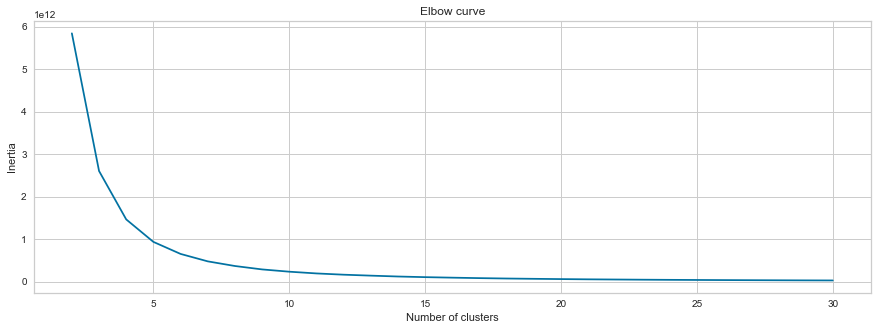

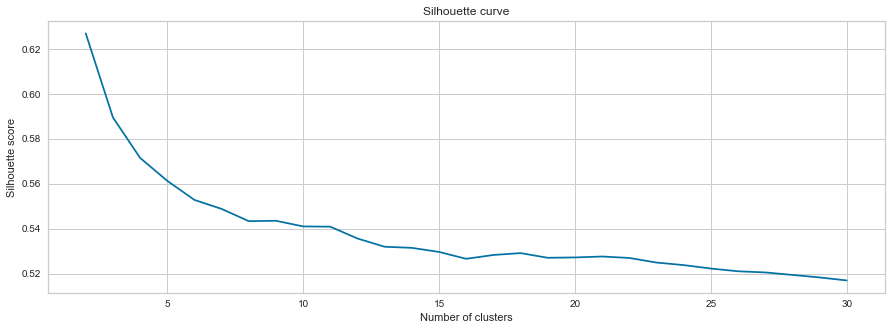

In [241]:
sse_insurance, silhouette_insurance = calculate_elbow_silhouette_kmeans(insurance_X_train, insurance_y_train, 30)

In [51]:
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4, random_state=10)
bench_k_means(kmeans=kmeans, name="k-means++ Patient D", data=patient_X_train, labels=patient_y_train)

kmeans = KMeans(init="random", n_clusters=2, n_init=4, random_state=10)
bench_k_means(kmeans=kmeans, name="random Patient D", data=patient_X_train, labels=patient_y_train)

kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4, random_state=10)
bench_k_means(kmeans=kmeans, name="k-means++ Insurance", data=insurance_X_train, labels=insurance_y_train)

kmeans = KMeans(init="random", n_clusters=2, n_init=4, random_state=10)
bench_k_means(kmeans=kmeans, name="random Insurance", data=insurance_X_train, labels=insurance_y_train)

pca = PCA(n_components=4).fit(patient_X_train)
kmeans = KMeans(init=pca.components_, n_clusters=4, n_init=4, random_state=10)
bench_k_means(kmeans=kmeans, name="PCA-based Patient", data=patient_X_train, labels=patient_y_train)

pca = PCA(n_components=4).fit(insurance_X_train)
kmeans = KMeans(init=pca.components_, n_clusters=4, n_init=4, random_state=10)
bench_k_means(kmeans=kmeans, name="PCA-based Insurance", data=insurance_X_train, labels=insurance_y_train)


__________________________________________________________________________________
init			time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++ Patient D	0.167s	2441176	0.029	0.027	0.028	0.031	0.028	0.038
random Patient D	0.165s	2441176	0.029	0.027	0.028	0.031	0.028	0.038
k-means++ Insurance	0.710s	16082059	0.002	0.002	0.002	0.010	0.002	0.000
random Insurance	0.887s	16082059	0.002	0.002	0.002	0.010	0.002	0.000


/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=4.
  self._check_params(X)


PCA-based Patient	0.088s	2265845	0.063	0.035	0.045	0.019	0.045	0.104


/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=4.
  self._check_params(X)


PCA-based Insurance	0.648s	14596617	0.055	0.026	0.036	0.012	0.036	-0.003


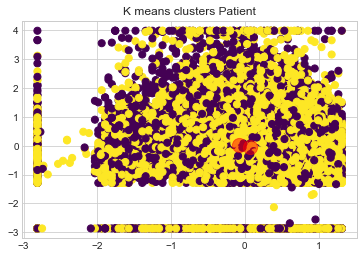

In [111]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init=4)
kmeans.fit(patient_X_resample_scaled)
y_kmeans = kmeans.predict(patient_X_resample_scaled)

plt.scatter(patient_X_resample_scaled[:, 0], patient_X_resample_scaled[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
plt.title("K means clusters Patient")
plt.show()

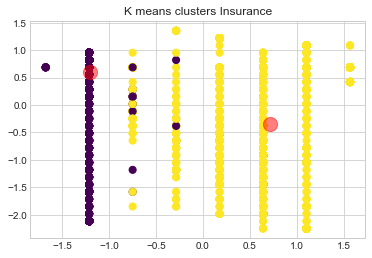

In [113]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init=4)
kmeans.fit(insurance_X_resample_scaled)
y_kmeans = kmeans.predict(insurance_X_resample_scaled)

plt.scatter(insurance_X_resample_scaled[:, 0], insurance_X_resample_scaled[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
plt.title("K means clusters Insurance")
plt.show()

In [237]:
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer

def generate_kmeans_SV_ICD_plots(X, k):
    plot_nums = len(k)
    fig, axes = plt.subplots(plot_nums, 2, figsize=[25, 40])
    col_ = 0
    for i in k:
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[col_][0])
        visualizer.fit(X)
        visualizer.finalize()
        
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = InterclusterDistance(kmeans, ax=axes[col_][1])
        visualizer.fit(X)
        visualizer.finalize()
        
        col_+=1
    plt.show()


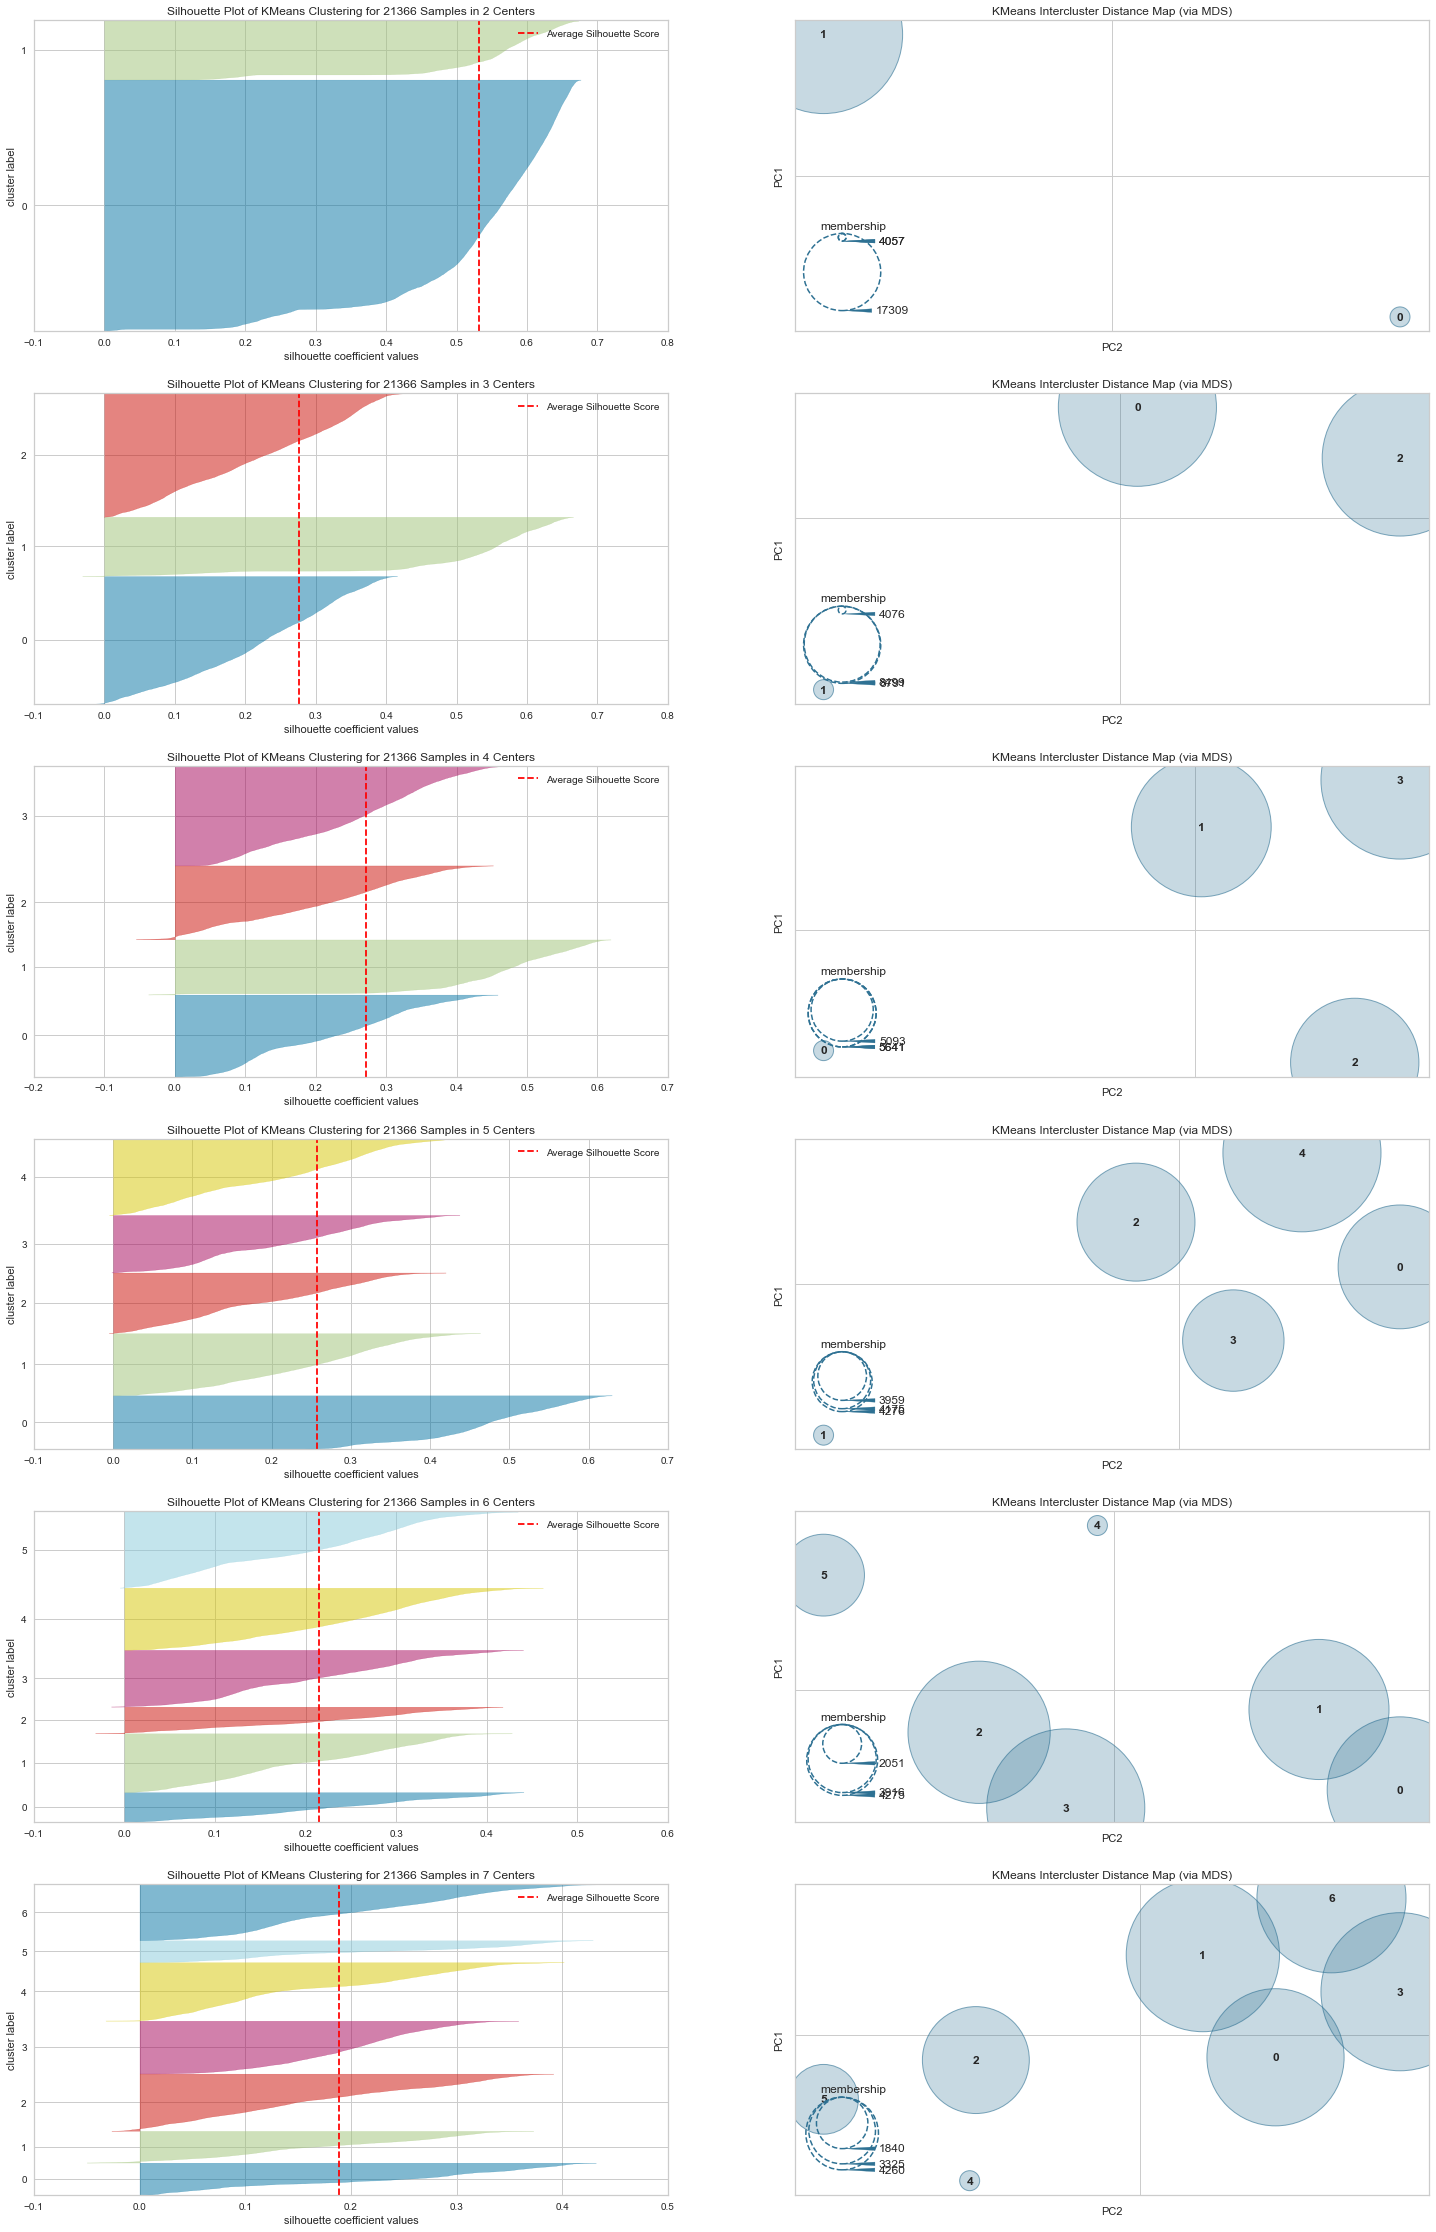

In [238]:
k = list(range(2,8))
generate_kmeans_SV_ICD_plots(patient_X_train, k)


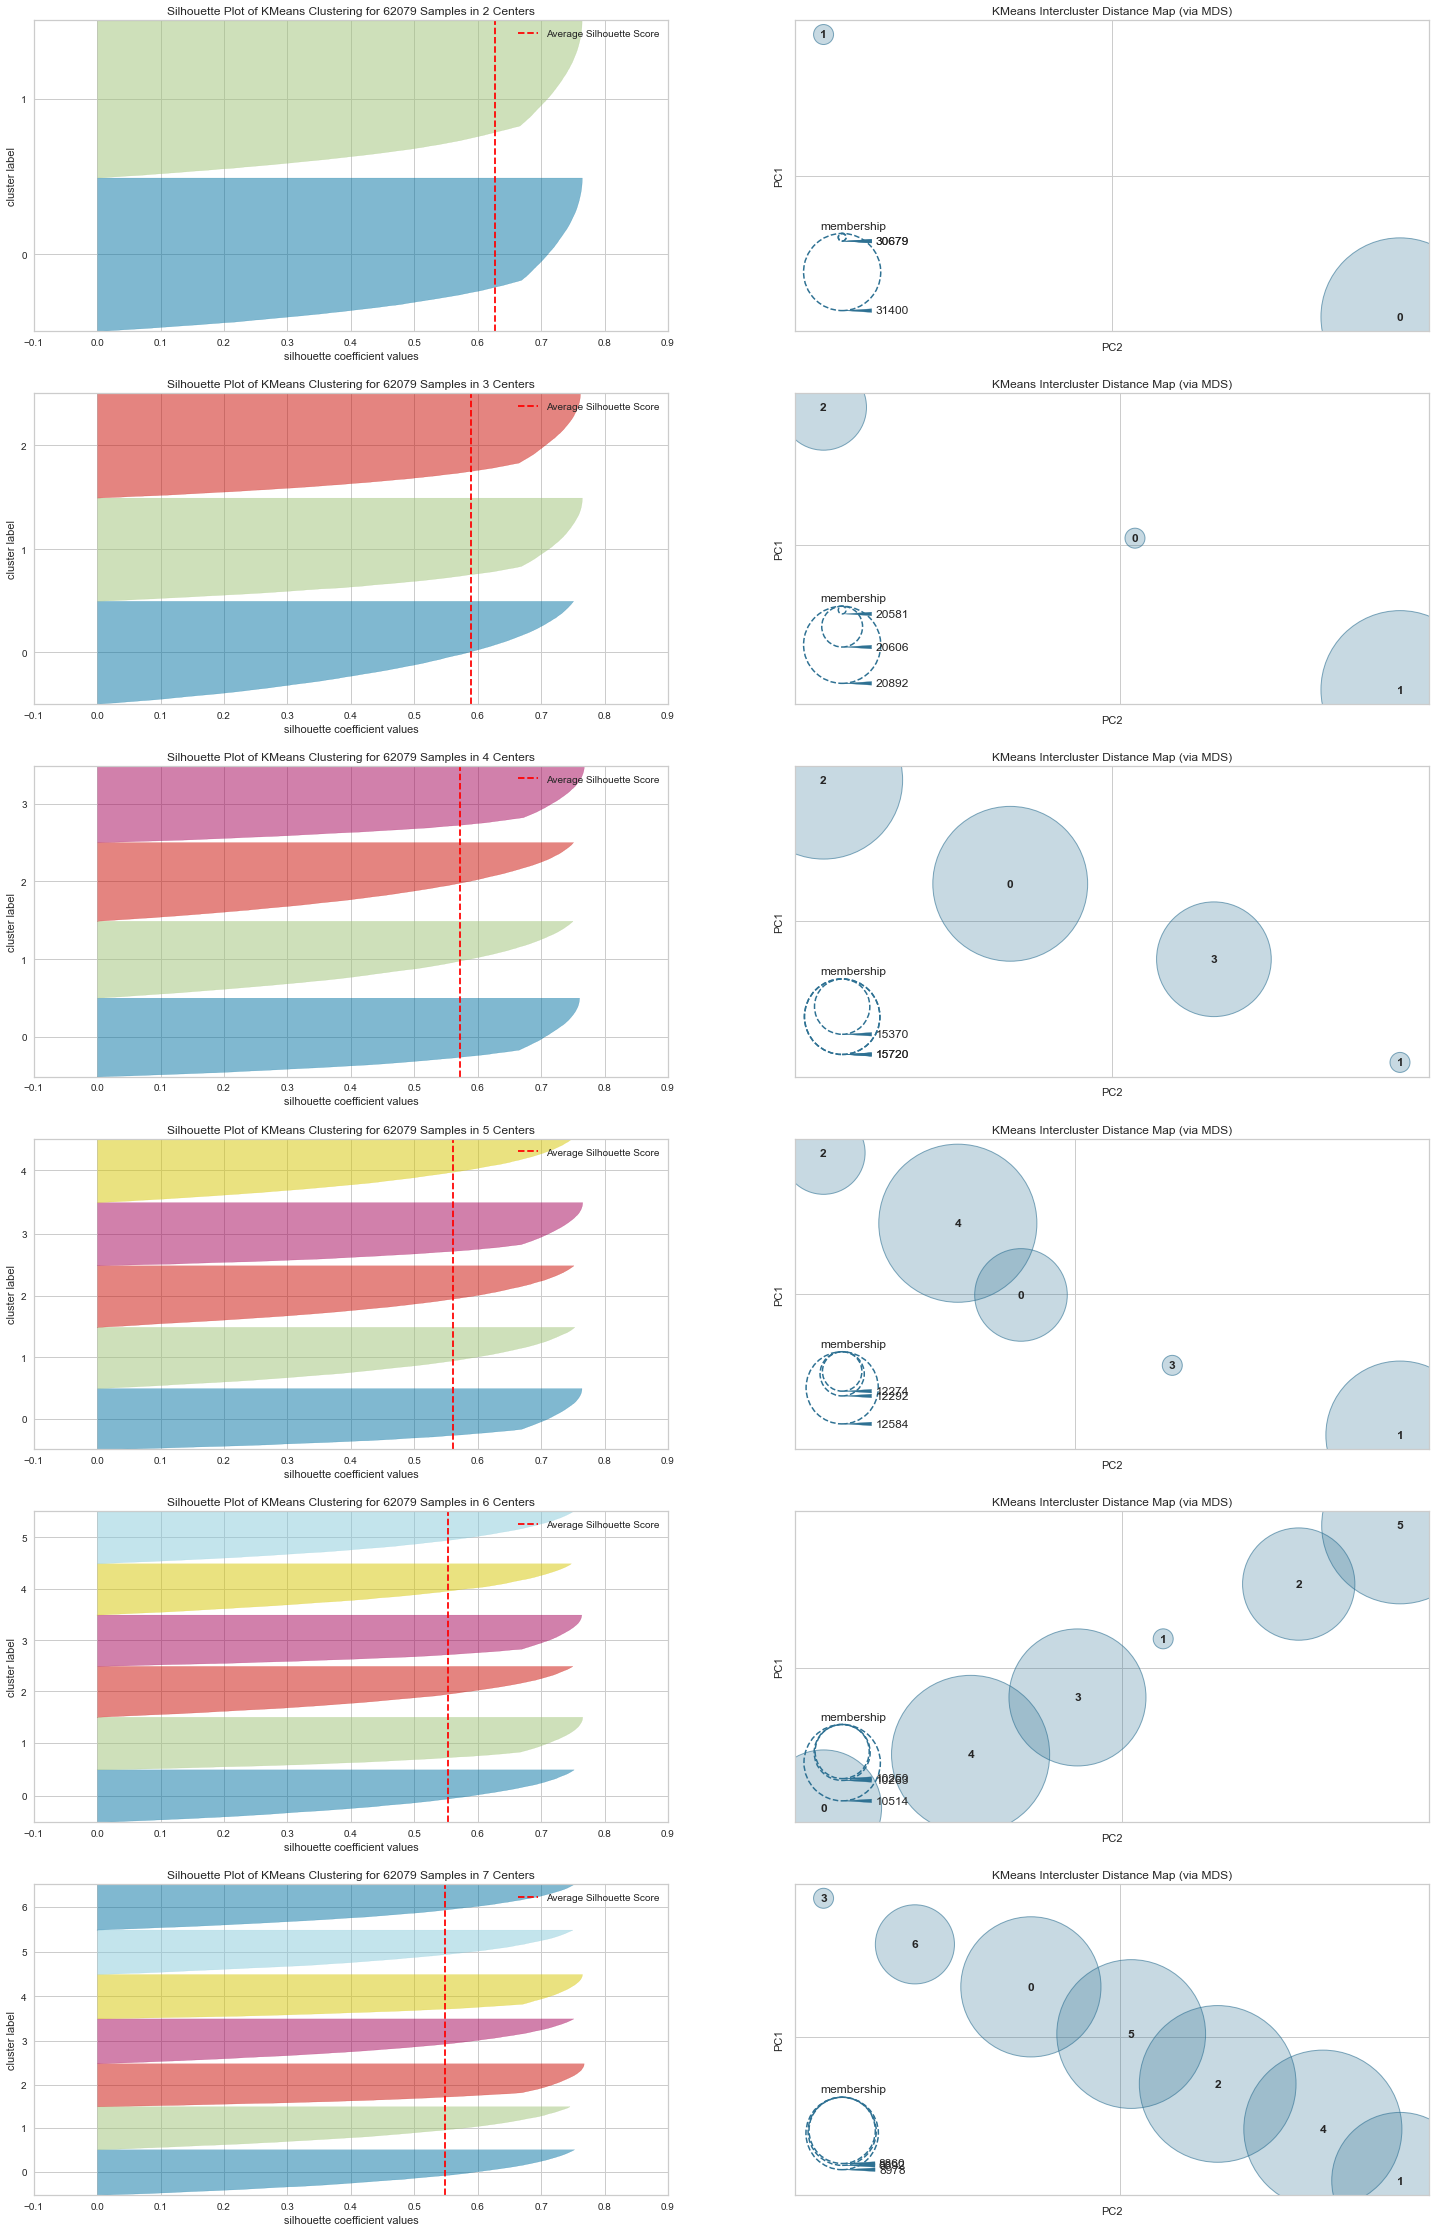

In [239]:
k = list(range(2,8))
generate_kmeans_SV_ICD_plots(insurance_X_train, k)


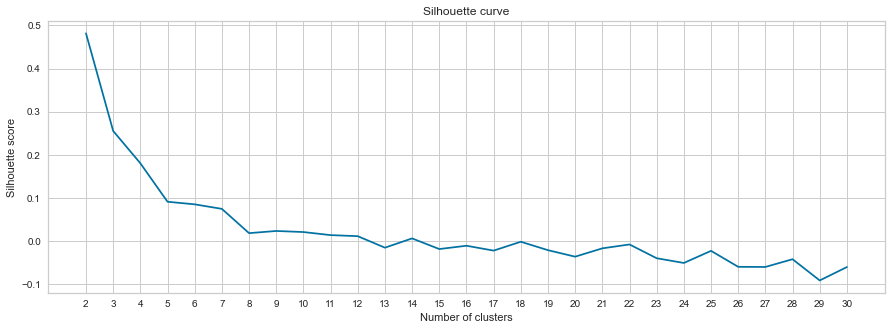

In [256]:
silhouette_patient_gm = calculate_silhouette_gaussian(patient_X_train, kmax=20)

In [19]:
silhouette_insurance_gm = calculate_silhouette_gaussian(insurance_X_train, kmax=15)

KeyboardInterrupt: 

In [42]:
def select_shorted_config(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

def gmm_js(gmm_p, gmm_q, n_samples=10000):
    
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)


def generate_distance_bw_gmms_plots(data, n):
    
    n_clusters=np.arange(2, n)
    iterations=n
    distances=[]
    distances_std=[]
    for n in n_clusters:
        dist=[]

        for iteration in range(iterations):
            train, test=train_test_split(data, test_size=0.5)

            gmm_train=GaussianMixture(n, n_init=2).fit(train) 
            gmm_test=GaussianMixture(n, n_init=2).fit(test) 
            dist.append(gmm_js(gmm_train, gmm_test))
            
        shorted_config=select_shorted_config(np.array(dist), int(iterations/5))
        
        result=np.mean(shorted_config)
        distance_std=np.std(shorted_config)

        distances.append(result)
        distances_std.append(distance_std)


    plt.errorbar(n_clusters, distances, yerr=distances_std)
    plt.title("Distance between Train and Test GMMs", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("Number of components")
    plt.ylabel("Distance")
    plt.show()


/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/opt/miniconda3/envs/ai_env/lib/python3.9/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


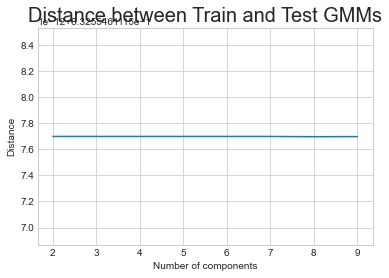

In [41]:
generate_distance_bw_gmms_plots(insurance_X_train[:5000,:], 10)

In [45]:
def generate_bic_plot(X, n):
    n_clusters=np.arange(2, n)
    bics=[]
    bics_err=[]
    iterations=n
    for n in n_clusters:
        tmp_bic=[]
        for _ in range(iterations):
            gmm=GaussianMixture(n, n_init=2).fit(X) 

            tmp_bic.append(gmm.bic(X))
        val=np.mean(select_shorted_config(np.array(tmp_bic), int(iterations/5)))
        err=np.std(tmp_bic)
        bics.append(val)
        bics_err.append(err)

    plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
    plt.title("BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("Number of components")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    plt.clf()
    
    plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
    plt.title("Gradient of BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("Number of components")
    plt.ylabel("gradient(BIC)")
    plt.legend()
    plt.show()
    plt.clf()


In [ ]:
generate_bic_plot(patient_X, 10)

In [93]:
gmm_patient=GaussianMixture(2, n_init=10, covariance_type="diag")
patient_X_train, patient_X_test, patient_y_train, patient_y_test = train_test_split(patient_X_resample_scaled, patient_Y_resample, test_size=0.2)

gmm_patient.fit(patient_X_train, patient_y_train)
patient_y_pred = gmm_patient.predict(patient_X_test)

score = roc_auc_score(patient_y_test, patient_y_pred)
sil_score = silhouette_score(patient_X_test, patient_y_pred)
f1 = f1_score(patient_y_test, patient_y_pred)
homo_score = homogeneity_score(patient_y_test, patient_y_pred)
aic_score = gmm_patient.aic(patient_X_test)
bic_score = gmm_patient.bic(patient_X_test)
accuracy = accuracy_score(patient_y_test, patient_y_pred)

print("ROC AUC Accuracy: " + str(score))
print(f"Test Accuracy: {accuracy}")
print(f"Test silhouette score: {sil_score}")
print(f"Test homo_score: {homo_score}")
print(f"Test f1_score: {f1}")
print(f"Test aic_score: {aic_score}")
print(f"Test bic_score: {bic_score}")


ROC AUC Accuracy: 0.5142115981509656
Test Accuracy: 0.6173428798727129
Test silhouette score: 0.18158497126172274
Test homo_score: 0.0009500017367476467
Test f1_score: 0.2582883577486508
Test aic_score: 155076004.70051974
Test bic_score: 155079194.33875132


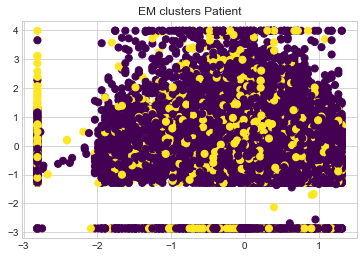

In [120]:
gmm_patient = GaussianMixture(2, n_init=10, covariance_type="diag")
gmm_patient.fit(patient_X_resample_scaled)
y_gmm = gmm_patient.predict(patient_X_resample_scaled)

plt.scatter(patient_X_resample_scaled[:, 0], patient_X_resample_scaled[:, 1], c=y_gmm, s=50, cmap='viridis')
plt.title("EM clusters Patient")
plt.show()

In [96]:
gmm_insurance=GaussianMixture(2, n_init=10, covariance_type="diag")

insurance_X_train, insurance_X_test, insurance_y_train, insurance_y_test = train_test_split(insurance_X_resample_scaled, insurance_Y_resample, test_size=0.2)
gmm_insurance.fit(insurance_X_train, insurance_y_train)
insurance_y_pred = gmm_insurance.predict(insurance_X_test)

score = roc_auc_score(insurance_y_test, insurance_y_pred)
sil_score = silhouette_score(insurance_X_test, insurance_y_pred)
f1 = f1_score(insurance_y_test, insurance_y_pred)
homo_score = homogeneity_score(insurance_y_test, insurance_y_pred)
aic_score = gmm_insurance.aic(insurance_X_test)
bic_score = gmm_insurance.bic(insurance_X_test)
accuracy = accuracy_score(insurance_y_test, insurance_y_pred)

print("ROC AUC Accuracy: " + str(score))
print(f"Test Accuracy: {accuracy}")
print(f"Test silhouette score: {sil_score}")
print(f"Test homo_score: {homo_score}")
print(f"Test f1_score: {f1}")
print(f"Test aic_score: {aic_score}")
print(f"Test bic_score: {bic_score}")

ROC AUC Accuracy: 0.5314482395523737
Test Accuracy: 0.5715752721298007
Test silhouette score: 0.13676637734179156
Test homo_score: 0.0029564613862314267
Test f1_score: 0.391008174386921
Test aic_score: 9527916.300874121
Test bic_score: 9537000.640479509


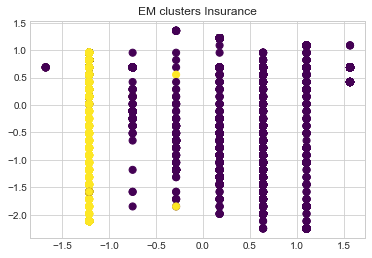

In [121]:
gmm_insurance = GaussianMixture(2, n_init=10, covariance_type="diag")
gmm_insurance.fit(insurance_X_resample_scaled)
y_gmm = gmm_insurance.predict(insurance_X_resample_scaled)

plt.scatter(insurance_X_resample_scaled[:, 0], insurance_X_resample_scaled[:, 1], c=y_gmm, s=50, cmap='viridis')
plt.title("EM clusters Insurance")
plt.show()

In [99]:
gmm_insurance=GaussianMixture(3, n_init=10, covariance_type="diag")

insurance_X_train, insurance_X_test, insurance_y_train, insurance_y_test = train_test_split(insurance_X_resample_scaled, insurance_Y_resample, test_size=0.2)
gmm_insurance.fit(insurance_X_train, insurance_y_train)
insurance_y_pred = gmm_insurance.predict(insurance_X_test)

score = roc_auc_score(insurance_y_test, insurance_y_pred)
sil_score = silhouette_score(insurance_X_test, insurance_y_pred)
f1 = f1_score(insurance_y_test, insurance_y_pred, average='weighted')
homo_score = homogeneity_score(insurance_y_test, insurance_y_pred)
aic_score = gmm_insurance.aic(insurance_X_test)
bic_score = gmm_insurance.bic(insurance_X_test)
accuracy = accuracy_score(insurance_y_test, insurance_y_pred)

print("ROC AUC Accuracy: " + str(score))
print(f"Test Accuracy: {accuracy}")
print(f"Test silhouette score: {sil_score}")
print(f"Test homo_score: {homo_score}")
print(f"Test f1_score: {f1}")
print(f"Test aic_score: {aic_score}")
print(f"Test bic_score: {bic_score}")

ROC AUC Accuracy: 0.6191431249013991
Test Accuracy: 0.32190045868419254
Test silhouette score: 0.14114016639482127
Test homo_score: 0.05172407892021639
Test f1_score: 0.41141146212964314
Test aic_score: 7075600.944685278
Test bic_score: 7089231.24872143
